In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [17]:
columns = ['cnt', 'timestamp', 't1', 't2', 'hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season']

df = pd.read_csv('data.csv', usecols=columns)

df['timestamp'] = df['timestamp'].str.slice(10,13)
df['timestamp'] = df['timestamp'].astype(int).astype(str)

In [18]:
from sklearn.model_selection import train_test_split

df['cnt']=np.log1p(df['cnt'])

df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.cnt.values
y_val = df_val.cnt.values
y_test = df_test.cnt.values

del df_train['cnt']
del df_val['cnt']
del df_test['cnt']

In [19]:
from sklearn.feature_extraction import DictVectorizer

train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(val_dict)

X_val = dv.transform(val_dict)

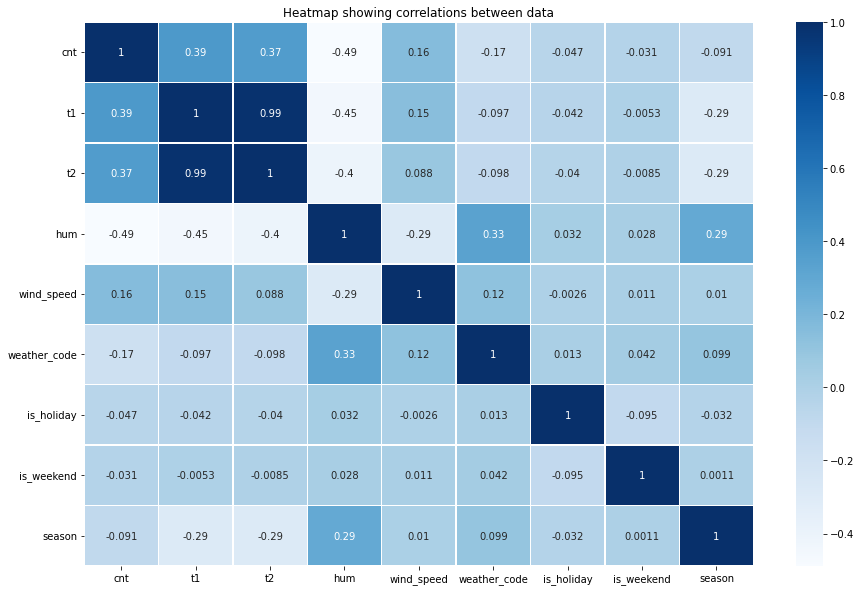

cnt           cnt             1.000000
t1            t1              1.000000
is_weekend    is_weekend      1.000000
is_holiday    is_holiday      1.000000
weather_code  weather_code    1.000000
                                ...   
hum           t2             -0.403495
t1            hum            -0.447781
hum           t1             -0.447781
              cnt            -0.488664
cnt           hum            -0.488664
Length: 81, dtype: float64

In [20]:
plt.figure(figsize=(15,10))  
sns.heatmap(df.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between data')
plt.show()

df.corr().unstack().sort_values(ascending = False)


In [21]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10, random_state = 1, n_jobs = -1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [25]:
from sklearn.metrics import mean_squared_log_error
from sklearn.tree import export_text

def rmse(y_true, y_pred):
	return(np.sqrt(mean_squared_log_error(y_true, y_pred)))

rmse(y_val,y_pred)

0.05520014987665731

In [26]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

print(export_text(dt, feature_names=dv.get_feature_names()))

|--- hum <= 69.75
|   |--- value: [7.15]
|--- hum >  69.75
|   |--- value: [6.01]



/home/kenwu/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
